In [1]:
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import yaml
import matplotlib.pyplot as plt
import warnings
import numpy as np
import cv2

warnings.filterwarnings("ignore")

C:\Users\Tony\PycharmProjects\BrainCancerDetection\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
with open(r"../config.yaml", "r") as yml_config:
    cfg = yaml.load(yml_config, Loader=yaml.FullLoader)

image_size = cfg["image"]["image_size"]
batch_size = cfg["image"]["batch_size"]

### Visualizing some of the brain MRI scans

Found 639 files belonging to 2 classes.


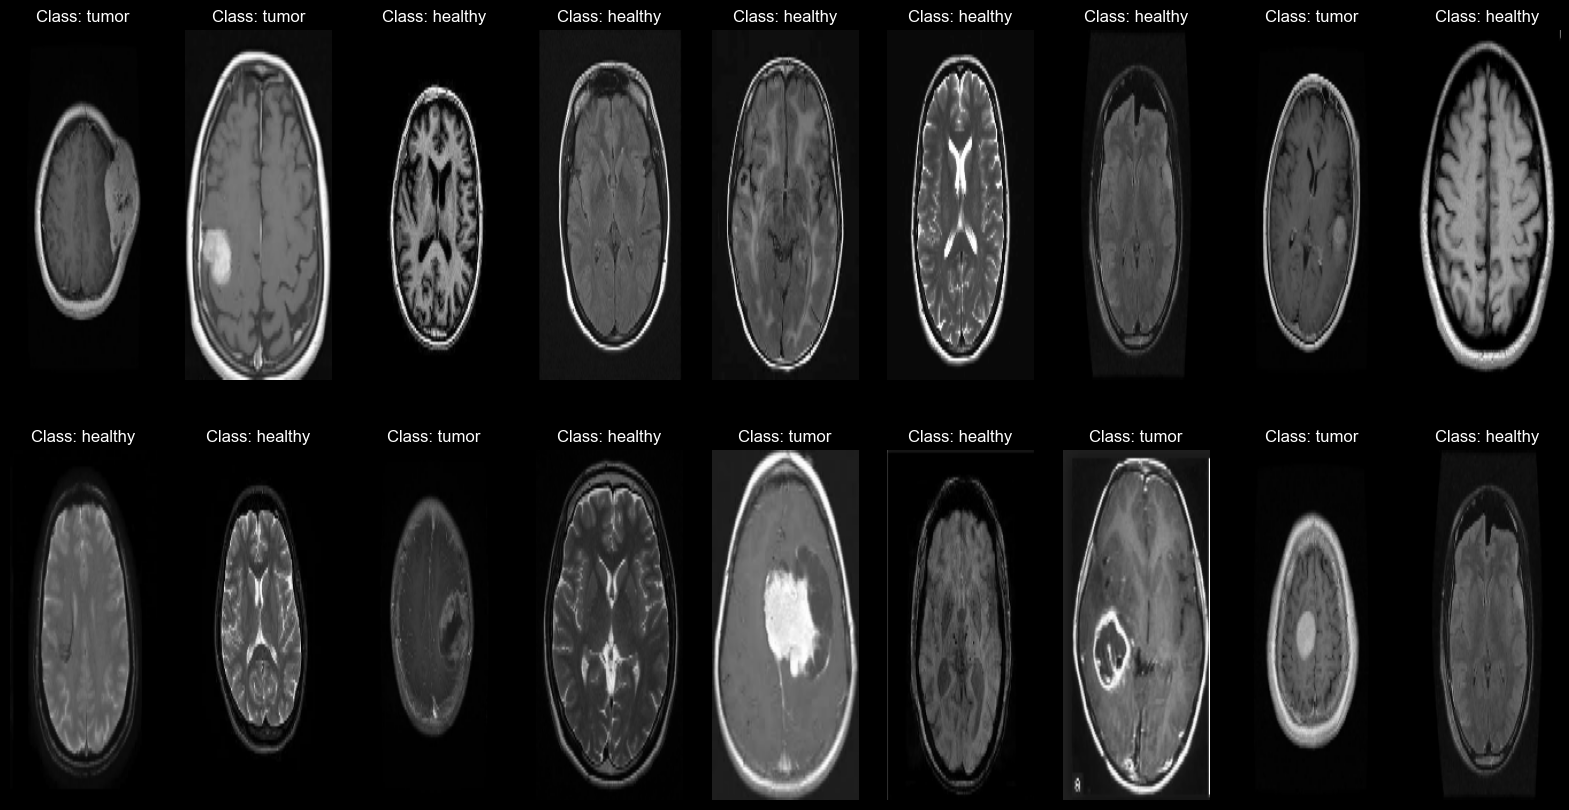

In [3]:
train_ds = image_dataset_from_directory(
    r"..\data\split\train",
    image_size=image_size,
    shuffle=True,
    batch_size=batch_size,
)

for images, labels in train_ds.take(1):
    plt.figure(figsize=(20, 10))
    for _ in range(18):
        ax = plt.subplot(2, 9, _ + 1)
        plt.imshow(images[_].numpy().astype("uint8"), aspect="auto")
        class_name = train_ds.class_names[labels[_]]
        plt.title(f'Class: {class_name}')
        plt.axis('off')
    plt.show()

### Resizing the dataset

In [4]:
import sys
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_data
from utils.resizing import resizing_data

In [5]:
path = r"C:\Users\Tony\PycharmProjects\BrainCancerDetection\data\split"
resizing_data(path)

# Reloading the data
train_ds, test_ds, val_ds = load_data(path)

0 images successfully resized
Found 639 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Found 81 files belonging to 2 classes.


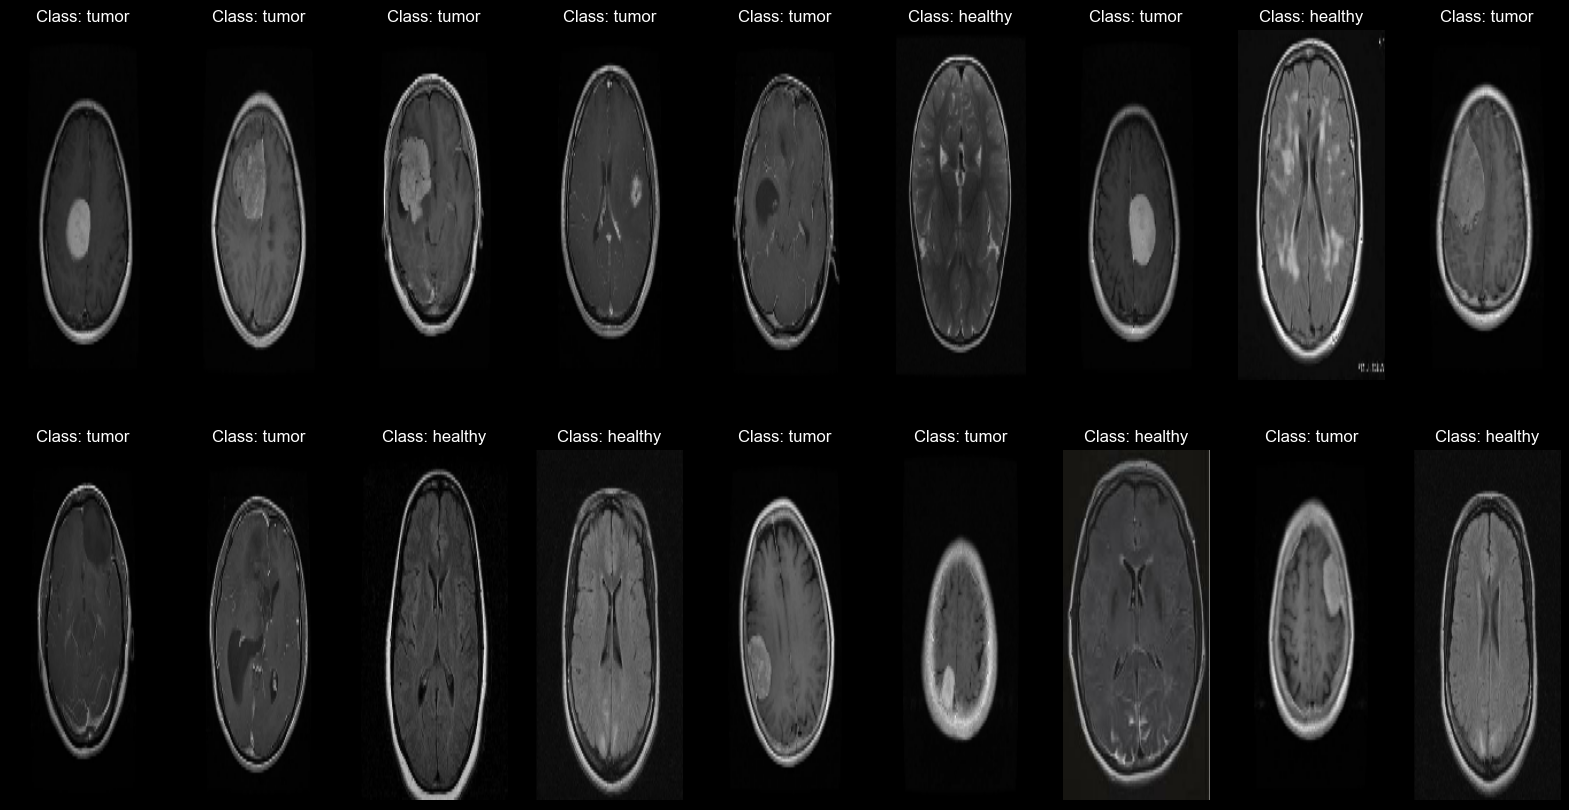

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(20, 10))
    for _ in range(18):
        ax = plt.subplot(2, 9, _ + 1)
        plt.imshow(images[_].numpy().astype("uint8"), aspect="auto")
        class_name = train_ds.class_names[labels[_]]
        plt.title(f'Class: {class_name}')
        plt.axis('off')
    plt.show()